# Phase 1: Business Understanding

## Problem
ต้องการวิเคราะห์และจำแนกโซนตลาดตามแนวคิด Wyckoff:
- Normal (ปกติ)
- Accumulation (สะสม)
- Distribution (กระจาย)

## Objective
1) ดึงข้อมูล OHLCV จาก Cassandra
2) สร้างฟีเจอร์ทางเทคนิค 35+ ตัว
3) ทำ Target Labeling แบบ Multi-Strategy Voting
4) ฝึก Deep Learning Hybrid Model (BiLSTM + BiGRU)
5) ประเมินผลด้วย Classification Report และ Confusion Matrix
6) แสดง Dashboard โซน Wyckoff

## Success Criteria
- Accuracy / F1-score สูงขึ้น
- โมเดลสามารถแยกโซนสะสมและกระจายได้ดีขึ้น


✅ Phase 2: Data Understanding

📌 Cell 1 — Imports + Configuration + Data Loading (Cassandra)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import seaborn as sns

from cassandra.cluster import Cluster

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, GRU, Bidirectional,
    Input, Concatenate, BatchNormalization,
    GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import AdamW

import warnings
warnings.filterwarnings('ignore')



In [17]:
# ========================================
# 1. Configuration
# ========================================
CASSANDRA_HOST = '127.0.0.1'
CASSANDRA_PORT = 9042
SYMBOL = 'CPALL'

WINDOW_SIZE = 30
LEARNING_RATE = 0.0003
EPOCHS = 120
BATCH_SIZE = 16


def get_data(symbol):
    try:
        cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
        session = cluster.connect('data_stock')
        query = f"""
        SELECT symbol, time, open, high, low, close, volume
        FROM candlestick_data
        WHERE symbol = '{symbol}'
        LIMIT 3000
        ALLOW FILTERING
        """
        df = pd.DataFrame(list(session.execute(query)))
        df['time'] = pd.to_datetime(df['time'])
        df.sort_values('time', inplace=True)
        cluster.shutdown()
        print(f"✅ Successfully loaded {len(df)} records for {symbol}")
        return df.reset_index(drop=True)
    except Exception as e:
        print(f"❌ Connection Error: {e}")
        return None


df_raw = get_data(SYMBOL)
df_raw.head()


✅ Successfully loaded 729 records for CPALL


,symbol,time,open,high,low,close,volume
0,CPALL,2023-01-17,68.00,69.00,68.00,68.75,27991828
1,CPALL,2023-01-18,68.75,68.75,67.75,68.50,47307718
2,CPALL,2023-01-19,68.50,68.75,68.25,68.75,19449645
3,CPALL,2023-01-20,68.50,68.50,67.25,68.00,24655509
4,CPALL,2023-01-23,68.50,69.50,68.50,69.25,22388807


📌 Cell 2 — Explore Data (info/describe/isnull)

In [18]:
print("Shape:", df_raw.shape)
display(df_raw.info())
display(df_raw.describe())

print("\nMissing values:")
display(df_raw.isnull().sum())


Shape: (729, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  729 non-null    object        
 1   time    729 non-null    datetime64[ns]
 2   open    729 non-null    float64       
 3   high    729 non-null    float64       
 4   low     729 non-null    float64       
 5   close   729 non-null    float64       
 6   volume  729 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 40.0+ KB


None

,time,open,high,low,close,volume
count,729,729.000000,729.000000,729.000000,729.000000,7.290000e+02
mean,2024-07-15 12:56:17.777777664,55.970508,56.510974,55.357682,55.913237,2.905420e+07
min,2023-01-17 00:00:00,40.750000,41.750000,40.500000,41.000000,3.908258e+06
25%,2023-10-16 00:00:00,50.250000,51.000000,49.500000,50.000000,1.779407e+07
50%,2024-07-16 00:00:00,56.250000,56.750000,55.500000,56.250000,2.456741e+07
75%,2025-04-11 00:00:00,62.500000,63.000000,61.750000,62.250000,3.425215e+07
max,2026-01-16 00:00:00,70.000000,70.250000,69.250000,70.000000,1.835202e+08
std,NaN,7.039612,7.026726,7.042556,7.048882,1.909169e+07



Missing values:


symbol    0
time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

✅ Phase 3: Data Preparation

📌 Cell 1 — Technical Indicators + Feature Engineering

In [19]:
# ========================================
# 3. Advanced Technical Indicators
# ========================================
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period, min_periods=1).mean()
    loss = (-delta.clip(upper=0)).rolling(window=period, min_periods=1).mean()
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))

def calculate_macd(series):
    ema_12 = series.ewm(span=12).mean()
    ema_26 = series.ewm(span=26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9).mean()
    histogram = macd - signal
    return macd, signal, histogram

def calculate_bbands(series, period=20):
    sma = series.rolling(period).mean()
    std = series.rolling(period).std()
    upper = sma + (2 * std)
    lower = sma - (2 * std)
    bb_position = (series - lower) / (upper - lower + 1e-10)
    bb_width = (upper - lower) / sma
    return bb_position, bb_width

def calculate_stochastic(df, period=14):
    low_min = df['low'].rolling(period).min()
    high_max = df['high'].rolling(period).max()
    k = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-10)
    d = k.rolling(3).mean()
    return k, d

def calculate_obv(df):
    obv = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    return obv

def calculate_mfi(df, period=14):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']

    positive_flow = pd.Series(0.0, index=df.index)
    negative_flow = pd.Series(0.0, index=df.index)

    positive_flow[typical_price > typical_price.shift(1)] = money_flow[typical_price > typical_price.shift(1)]
    negative_flow[typical_price < typical_price.shift(1)] = money_flow[typical_price < typical_price.shift(1)]

    mfr = positive_flow.rolling(period).sum() / (negative_flow.rolling(period).sum() + 1e-10)
    mfi = 100 - (100 / (1 + mfr))
    return mfi

# ========================================
# 4. Comprehensive Feature Engineering
# ========================================
def prepare_advanced_features(df):
    df = df.copy()

    # === Basic Price Features ===
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['high_low_spread'] = (df['high'] - df['low']) / df['close']
    df['close_open_spread'] = (df['close'] - df['open']) / df['open']
    df['high_low_ratio'] = df['high'] / df['low']

    # === Volume Features ===
    for period in [5, 10, 20, 30]:
        df[f'volume_ma_{period}'] = df['volume'].rolling(period).mean()
        df[f'volume_ratio_{period}'] = df['volume'] / (df[f'volume_ma_{period}'] + 1)

    df['volume_momentum'] = df['volume'].pct_change(5)
    df['volume_std'] = df['volume'].rolling(20).std()

    # === Moving Averages ===
    for period in [5, 10, 20, 50, 100]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period).mean()

    # === Distance from MAs ===
    for period in [10, 20, 50]:
        df[f'dist_from_sma_{period}'] = (df['close'] - df[f'sma_{period}']) / df[f'sma_{period}']
        df[f'dist_from_ema_{period}'] = (df['close'] - df[f'ema_{period}']) / df[f'ema_{period}']

    # === Technical Indicators ===
    df['rsi'] = calculate_rsi(df['close'], 14)
    df['rsi_slope'] = df['rsi'].diff(5)

    df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(df['close'])
    df['macd_cross'] = (df['macd'] > df['macd_signal']).astype(int)

    df['stoch_k'], df['stoch_d'] = calculate_stochastic(df)
    df['bb_position'], df['bb_width'] = calculate_bbands(df['close'])

    df['obv'] = calculate_obv(df)
    df['obv_slope'] = df['obv'].diff(5)
    df['mfi'] = calculate_mfi(df, 14)

    # === Volatility ===
    for period in [5, 10, 20]:
        df[f'volatility_{period}'] = df['returns'].rolling(period).std()
        df[f'atr_{period}'] = df['high_low_spread'].rolling(period).mean()

    # === Price Action ===
    df['body'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['close', 'open']].max(axis=1)
    df['lower_shadow'] = df[['close', 'open']].min(axis=1) - df['low']
    df['body_pct'] = df['body'] / (df['high_low_spread'] + 1e-10)
    df['upper_shadow_pct'] = df['upper_shadow'] / (df['high_low_spread'] + 1e-10)
    df['lower_shadow_pct'] = df['lower_shadow'] / (df['high_low_spread'] + 1e-10)

    # === Momentum ===
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close'].diff(period)
        df[f'roc_{period}'] = df['close'].pct_change(period)

    # === Trend Features ===
    df['price_above_sma20'] = (df['close'] > df['sma_20']).astype(int)
    df['price_above_sma50'] = (df['close'] > df['sma_50']).astype(int)
    df['sma_trend'] = (df['sma_20'] > df['sma_50']).astype(int)

    # === Wyckoff Events ===
    df['high_volume'] = (df['volume'] > df['volume_ma_30'] * 2.0).astype(int)
    df['SC'] = ((df['high_volume'] == 1) &
                (df['low'] == df['low'].rolling(30).min()) &
                (df['close'] < df['open'])).astype(int)
    df['BC'] = ((df['high_volume'] == 1) &
                (df['high'] == df['high'].rolling(30).max()) &
                (df['close'] < df['open'])).astype(int)

    # AR Detection
    df['AR'] = 0
    for i in df.index[df['SC'] | df['BC']]:
        if i + 10 < len(df):
            if df.loc[i, 'SC']:
                ar_idx = df.loc[i:i+10, 'high'].idxmax()
            else:
                ar_idx = df.loc[i:i+10, 'low'].idxmin()
            df.at[ar_idx, 'AR'] = 1

    # Spring Detection
    support = df['low'].rolling(60).min().shift(1)
    df['SPRING'] = ((df['low'] < support) &
                    (df['close'] > support) &
                    (df['high_volume'] == 1) &
                    (df['close'] > df['open'])).astype(int)

    return df.dropna().reset_index(drop=True)


df_feat = prepare_advanced_features(df_raw)
print("✅ Features created:", df_feat.shape)
df_feat.head()


✅ Features created: (630, 77)


,symbol,time,open,high,low,close,volume,returns,log_returns,high_low_spread,...,momentum_20,roc_20,price_above_sma20,price_above_sma50,sma_trend,high_volume,SC,BC,AR,SPRING
0,CPALL,2023-06-15,64.50,64.75,64.00,64.25,19929660,0.000000,0.000000,0.011673,...,1.25,0.019841,1,1,0,0,0,0,0,0
1,CPALL,2023-06-16,64.50,64.75,64.00,64.50,30253296,0.003891,0.003884,0.011628,...,2.00,0.032000,1,1,0,0,0,0,0,0
2,CPALL,2023-06-19,64.50,64.75,64.00,64.00,7119035,-0.007752,-0.007782,0.011719,...,2.25,0.036437,1,1,0,0,0,0,0,0
3,CPALL,2023-06-20,64.00,64.50,63.50,64.00,16567290,0.000000,0.000000,0.015625,...,2.00,0.032258,1,1,0,0,0,0,0,0
4,CPALL,2023-06-21,63.75,64.00,62.75,63.25,17408196,-0.011719,-0.011788,0.019763,...,1.00,0.016064,0,0,0,0,0,0,0,0


📌 Cell 2 — Target Labeling (Multi-Strategy Voting)

In [20]:
# ========================================
# 5. Smart Multi-Strategy Target Labeling (FIXED)
# ========================================
def create_smart_targets(df, vote_threshold=4, neutral_margin=1):
    """
    FIX 1: ลด label noise
    - vote_threshold จากเดิม 3 -> 4
    - neutral_margin: ถ้าคะแนนสูสีกันมาก ให้เป็น Normal
    """
    df = df.copy()
    df['target'] = 0

    volume_high = df['volume_ratio_30'] > df['volume_ratio_30'].quantile(0.70)

    price_low = df['close'] < df['sma_50']
    price_high = df['close'] > df['sma_50']

    rsi_oversold = df['rsi'] < 40
    rsi_overbought = df['rsi'] > 60

    mfi_oversold = df['mfi'] < 35
    mfi_overbought = df['mfi'] > 65

    bb_low = df['bb_position'] < 0.25
    bb_high = df['bb_position'] > 0.75

    stoch_oversold = df['stoch_k'] < 20
    stoch_overbought = df['stoch_k'] > 80

    macd_bullish = (df['macd'] > df['macd_signal']) & (df['macd_hist'] > 0)
    macd_bearish = (df['macd'] < df['macd_signal']) & (df['macd_hist'] < 0)

    accum_votes = (
        (price_low & volume_high).astype(int) +
        rsi_oversold.astype(int) +
        mfi_oversold.astype(int) +
        bb_low.astype(int) +
        stoch_oversold.astype(int) +
        macd_bullish.astype(int) +
        (df['close'] > df['open']).astype(int)
    )

    dist_votes = (
        (price_high & volume_high).astype(int) +
        rsi_overbought.astype(int) +
        mfi_overbought.astype(int) +
        bb_high.astype(int) +
        stoch_overbought.astype(int) +
        macd_bearish.astype(int) +
        (df['close'] < df['open']).astype(int)
    )

    # --- FIX: ถ้า accum/dist ได้คะแนนถึง threshold จริง ๆ ค่อยติดป้าย ---
    df.loc[accum_votes >= vote_threshold, 'target'] = 1
    df.loc[dist_votes >= vote_threshold, 'target'] = 2

    # --- FIX: conflict handling ---
    conflicts = (accum_votes >= vote_threshold) & (dist_votes >= vote_threshold)

    # ถ้าสูสีกันมาก ให้กลับไป Normal
    close_conflict = conflicts & (abs(accum_votes - dist_votes) <= neutral_margin)
    df.loc[close_conflict, 'target'] = 0

    # ถ้าไม่สูสี ให้เลือกฝั่งคะแนนมากกว่า
    df.loc[conflicts & (accum_votes > dist_votes) & (~close_conflict), 'target'] = 1
    df.loc[conflicts & (dist_votes > accum_votes) & (~close_conflict), 'target'] = 2

    print("\n" + "="*80)
    print("TARGET DISTRIBUTION (FIXED Labeling)")
    print("="*80)
    target_counts = df['target'].value_counts().sort_index()
    for label, count in target_counts.items():
        pct = (count / len(df)) * 100
        label_name = ['Normal', 'Accumulation', 'Distribution'][label]
        print(f"{label_name:15} : {count:5} ({pct:6.2f}%)")

    return df


df_labeled = create_smart_targets(df_feat, vote_threshold=4, neutral_margin=1)
df_labeled[['time','close','target']].head()



TARGET DISTRIBUTION (FIXED Labeling)
Normal          :   432 ( 68.57%)
Accumulation    :   124 ( 19.68%)
Distribution    :    74 ( 11.75%)


,time,close,target
0,2023-06-15,64.25,2
1,2023-06-16,64.50,2
2,2023-06-19,64.00,0
3,2023-06-20,64.00,0
4,2023-06-21,63.25,0


✅ Phase 4: Modeling

📌 Cell 1 — Data Augmentation + Hybrid Model + Training

In [21]:
# ========================================
# 6. Data Augmentation
# ========================================
def augment_sequences(X, y, augment_factor=1):
    """
    FIX: ลด augmentation เพื่อกัน noise
    จากเดิม 2 -> 1 (เบาลง)
    """
    X_aug, y_aug = [X], [y]

    for _ in range(augment_factor):
        # Jittering (ลด noise)
        noise = np.random.normal(0, 0.003, X.shape)  # เดิม 0.01
        X_jittered = X + noise
        X_aug.append(X_jittered)
        y_aug.append(y)

        # Scaling (ลด range)
        scale = np.random.uniform(0.99, 1.01, (X.shape[0], 1, 1))
        X_scaled = X * scale
        X_aug.append(X_scaled)
        y_aug.append(y)

    return np.concatenate(X_aug), np.concatenate(y_aug)


In [22]:
# ========================================
# 7. Advanced Hybrid Model (SMALLER)
# ========================================
def create_hybrid_model(input_shape, num_classes=3):
    """
    FIX 2: ลดขนาดโมเดลเพื่อลด overfitting
    """
    inputs = Input(shape=input_shape)

    # Branch 1: Bidirectional LSTM (ลด units)
    lstm_out = Bidirectional(LSTM(32, return_sequences=True))(inputs)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.35)(lstm_out)

    # Branch 2: Bidirectional GRU (ลด units)
    gru_out = Bidirectional(GRU(32, return_sequences=True))(inputs)
    gru_out = BatchNormalization()(gru_out)
    gru_out = Dropout(0.35)(gru_out)

    merged = Concatenate()([lstm_out, gru_out])

    # Additional LSTM layer (ลด units)
    x = LSTM(32, return_sequences=True)(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    pooled = GlobalAveragePooling1D()(x)

    # Dense layers (ลดขนาด)
    dense = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005))(pooled)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.4)(dense)

    dense = Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005))(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)

    outputs = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [23]:
# ========================================
# 8. Advanced Training
# ========================================
def train_advanced_dl_model(df, window_size=WINDOW_SIZE):
    feature_cols = [
        'returns', 'log_returns', 'volume_ratio_10', 'volume_ratio_30',
        'rsi', 'rsi_slope', 'macd', 'macd_hist',
        'stoch_k', 'stoch_d', 'mfi', 'obv_slope',
        'dist_from_sma_10', 'dist_from_sma_20', 'dist_from_sma_50',
        'dist_from_ema_10', 'dist_from_ema_20',
        'volatility_5', 'volatility_20', 'atr_10',
        'bb_position', 'bb_width',
        'body_pct', 'upper_shadow_pct', 'lower_shadow_pct',
        'momentum_5', 'momentum_20',
        'sma_trend', 'price_above_sma20'
    ]

    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(df[feature_cols])

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i])
        y.append(df['target'].iloc[i])

    X = np.array(X)
    y = np.array(y)

    print(f"\n📊 Original dataset: {len(X)} samples")

    # Time-series split
    split = int(len(X) * 0.90)  # FIX: 0.85 -> 0.90 ให้ val น้อยลงหน่อย
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    # Augmentation (เบาลง)
    print("🔄 Applying data augmentation...")
    X_train_aug, y_train_aug = augment_sequences(X_train, y_train, augment_factor=1)
    print(f"📈 Augmented dataset: {len(X_train_aug)} samples")

    # Class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_aug),
        y=y_train_aug
    )
    class_weight_dict = dict(enumerate(class_weights))

    print("\n⚖️  Class Weights:")
    for cls, weight in class_weight_dict.items():
        print(f"   Class {cls}: {weight:.3f}")

    model = create_hybrid_model((window_size, len(feature_cols)))

    optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=0.001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n🏗️  Model Architecture:")
    print(f"   Total Parameters: {model.count_params():,}")

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,  # FIX: 20 -> 15 ตัดเร็วขึ้น
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=6,   # FIX: 8 -> 6
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_wyckoff_dl_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    print("\n🚀 Training Advanced Deep Learning Model...")
    print("="*80)

    history = model.fit(
        X_train_aug, y_train_aug,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    # Predict full
    df = df.copy()
    df['dl_zone'] = 0
    full_preds = np.argmax(model.predict(X, verbose=0), axis=1)
    df.iloc[window_size:, df.columns.get_loc('dl_zone')] = full_preds

    return df, model, history, (X_val, y_val), scaler


df_final, model, history, (X_val, y_val), scaler = train_advanced_dl_model(df_labeled)



📊 Original dataset: 600 samples
🔄 Applying data augmentation...
📈 Augmented dataset: 1620 samples

⚖️  Class Weights:
   Class 0: 0.497
   Class 1: 1.682
   Class 2: 2.535

🏗️  Model Architecture:
   Total Parameters: 51,043

🚀 Training Advanced Deep Learning Model...
Epoch 1/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3381 - loss: 3.1413
Epoch 1: val_accuracy improved from None to 0.01667, saving model to best_wyckoff_dl_model.h5



Epoch 1: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3500 - loss: 3.0502 - val_accuracy: 0.0167 - val_loss: 2.7133 - learning_rate: 3.0000e-04
Epoch 2/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3927 - loss: 2.9104
Epoch 2: val_accuracy improved from 0.01667 to 0.06667, saving model to best_wyckoff_dl_model.h5



Epoch 2: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3926 - loss: 2.8543 - val_accuracy: 0.0667 - val_loss: 2.8153 - learning_rate: 3.0000e-04
Epoch 3/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3937 - loss: 2.7159
Epoch 3: val_accuracy improved from 0.06667 to 0.30000, saving model to best_wyckoff_dl_model.h5



Epoch 3: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4216 - loss: 2.6655 - val_accuracy: 0.3000 - val_loss: 2.7900 - learning_rate: 3.0000e-04
Epoch 4/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4717 - loss: 2.5432
Epoch 4: val_accuracy did not improve from 0.30000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4636 - loss: 2.5446 - val_accuracy: 0.1833 - val_loss: 2.7783 - learning_rate: 3.0000e-04
Epoch 5/120
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4300 - loss: 2.4774
Epoch 5: val_accuracy did not improve from 0.30000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4352 - loss: 2.5172 - val_accuracy: 0.1833 - val_loss: 2.7699 - learning_rate: 3.0000e-04
Epoch 6/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4649 - loss: 2.5098
Epoch 6: val_accuracy did not improve from 0.30000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4648 - loss: 2.4476 - val_acc


Epoch 7: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4846 - loss: 2.3152 - val_accuracy: 0.3667 - val_loss: 2.6617 - learning_rate: 3.0000e-04
Epoch 8/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5078 - loss: 2.2778
Epoch 8: val_accuracy did not improve from 0.36667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5080 - loss: 2.2669 - val_accuracy: 0.2500 - val_loss: 2.7165 - learning_rate: 3.0000e-04
Epoch 9/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5109 - loss: 2.2534
Epoch 9: val_accuracy did not improve from 0.36667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5099 - loss: 2.2295 - val_accuracy: 0.2833 - val_loss: 2.6938 - learning_rate: 3.0000e-04
Epoch 10/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5559 - loss: 2.1817
Epoch 10: val_accuracy did not improve from 0.36667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5327 - loss: 2.1791 - val_a


Epoch 11: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5210 - loss: 2.1273 - val_accuracy: 0.4167 - val_loss: 2.4194 - learning_rate: 3.0000e-04
Epoch 12/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5348 - loss: 2.1486
Epoch 12: val_accuracy did not improve from 0.41667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5228 - loss: 2.0987 - val_accuracy: 0.4000 - val_loss: 2.3832 - learning_rate: 3.0000e-04
Epoch 13/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5059 - loss: 2.0854
Epoch 13: val_accuracy did not improve from 0.41667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5154 - loss: 2.0880 - val_accuracy: 0.4167 - val_loss: 2.3744 - learning_rate: 3.0000e-04
Epoch 14/120
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5408 - loss: 2.0748
Epoch 14: val_accuracy improved from 0.41667 to 0.48333, saving model to best_wyckoff_dl_model.h5



Epoch 14: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5352 - loss: 2.0431 - val_accuracy: 0.4833 - val_loss: 2.2882 - learning_rate: 3.0000e-04
Epoch 15/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5509 - loss: 1.9758
Epoch 15: val_accuracy did not improve from 0.48333
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5389 - loss: 1.9836 - val_accuracy: 0.4167 - val_loss: 2.3465 - learning_rate: 3.0000e-04
Epoch 16/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5583 - loss: 1.9597
Epoch 16: val_accuracy improved from 0.48333 to 0.56667, saving model to best_wyckoff_dl_model.h5



Epoch 16: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5525 - loss: 1.9439 - val_accuracy: 0.5667 - val_loss: 2.2504 - learning_rate: 3.0000e-04
Epoch 17/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5437 - loss: 1.9250
Epoch 17: val_accuracy improved from 0.56667 to 0.58333, saving model to best_wyckoff_dl_model.h5



Epoch 17: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5525 - loss: 1.9214 - val_accuracy: 0.5833 - val_loss: 2.2036 - learning_rate: 3.0000e-04
Epoch 18/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5661 - loss: 1.8796
Epoch 18: val_accuracy did not improve from 0.58333
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5463 - loss: 1.8874 - val_accuracy: 0.4833 - val_loss: 2.2936 - learning_rate: 3.0000e-04
Epoch 19/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5560 - loss: 1.8746
Epoch 19: val_accuracy did not improve from 0.58333
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5704 - loss: 1.8369 - val_accuracy: 0.5167 - val_loss: 2.1801 - learning_rate: 3.0000e-04
Epoch 20/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6123 - loss: 1.7934
Epoch 20: val_accuracy did not improve from 0.58333
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6037 - loss: 1.7686 - 


Epoch 23: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6074 - loss: 1.6897 - val_accuracy: 0.6000 - val_loss: 2.0191 - learning_rate: 3.0000e-04
Epoch 24/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6261 - loss: 1.6331
Epoch 24: val_accuracy did not improve from 0.60000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6093 - loss: 1.6590 - val_accuracy: 0.5000 - val_loss: 2.2074 - learning_rate: 3.0000e-04
Epoch 25/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6113 - loss: 1.6308
Epoch 25: val_accuracy did not improve from 0.60000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6123 - loss: 1.6478 - val_accuracy: 0.3333 - val_loss: 2.4465 - learning_rate: 3.0000e-04
Epoch 26/120
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6356 - loss: 1.5949
Epoch 26: val_accuracy did not improve from 0.60000
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6469 - loss: 1.5800 - 


Epoch 38: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6833 - loss: 1.3350 - val_accuracy: 0.6167 - val_loss: 1.7899 - learning_rate: 1.5000e-04
Epoch 39/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7188 - loss: 1.2823
Epoch 39: val_accuracy did not improve from 0.61667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7130 - loss: 1.2754 - val_accuracy: 0.5167 - val_loss: 1.9106 - learning_rate: 1.5000e-04
Epoch 40/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7105 - loss: 1.2674
Epoch 40: val_accuracy did not improve from 0.61667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7025 - loss: 1.2684 - val_accuracy: 0.5167 - val_loss: 1.8689 - learning_rate: 1.5000e-04
Epoch 41/120
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7113 - loss: 1.2709
Epoch 41: val_accuracy did not improve from 0.61667
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6988 - loss: 1.2787 - 


Epoch 70: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7519 - loss: 0.9322 - val_accuracy: 0.6667 - val_loss: 1.4857 - learning_rate: 3.7500e-05
Epoch 71/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7667 - loss: 0.9251
Epoch 71: val_accuracy improved from 0.66667 to 0.68333, saving model to best_wyckoff_dl_model.h5



Epoch 71: finished saving model to best_wyckoff_dl_model.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7617 - loss: 0.9378 - val_accuracy: 0.6833 - val_loss: 1.4600 - learning_rate: 3.7500e-05
Epoch 72/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7705 - loss: 0.9037
Epoch 72: val_accuracy did not improve from 0.68333
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7648 - loss: 0.9051 - val_accuracy: 0.6833 - val_loss: 1.4631 - learning_rate: 3.7500e-05
Epoch 73/120
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7489 - loss: 0.9468
Epoch 73: val_accuracy did not improve from 0.68333
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7500 - loss: 0.9347 - val_accuracy: 0.6667 - val_loss: 1.4837 - learning_rate: 3.7500e-05
Epoch 74/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7580 - loss: 0.9645
Epoch 74: val_accuracy did not improve from 0.68333
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7519 - loss: 0.9420 - 

✅ Phase 5: Evaluation

📌 Cell 1 — Classification Report + Confusion Matrix

In [24]:
y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)

print("\n📋 Classification Report:")
print("-" * 80)
print(classification_report(
    y_val, y_pred,
    target_names=['Normal', 'Accumulation', 'Distribution'],
    digits=4
))

f1 = f1_score(y_val, y_pred, average='weighted')
print("\n🎯 Weighted F1 Score:", f"{f1:.4f}")



📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.7955    0.7955    0.7955        44
Accumulation     0.6667    0.4000    0.5000        15
Distribution     0.0000    0.0000    0.0000         1

    accuracy                         0.6833        60
   macro avg     0.4874    0.3985    0.4318        60
weighted avg     0.7500    0.6833    0.7083        60


🎯 Weighted F1 Score: 0.7083


✅ Phase 6: Visualization

📌 Cell 1 — Dashboard + Training History    

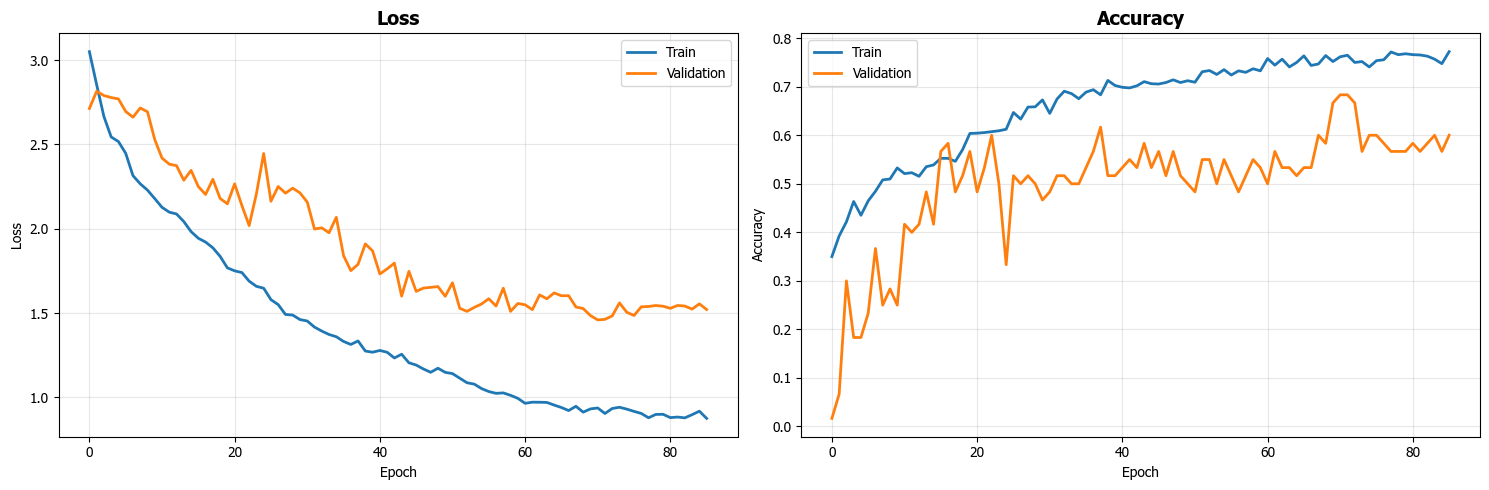

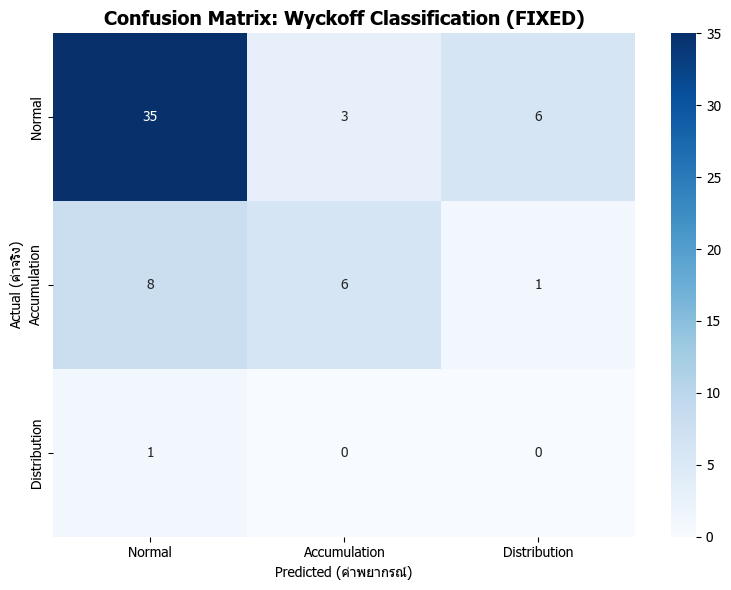

In [27]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_training_history(history)


# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))

unique_val_classes = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred, labels=unique_val_classes)

target_names = ['Normal', 'Accumulation', 'Distribution']
valid_labels = [target_names[i] for i in unique_val_classes]

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=valid_labels,
    yticklabels=valid_labels
)

plt.title('Confusion Matrix: Wyckoff Classification (FIXED)', fontsize=14, fontweight='bold')
plt.ylabel('Actual (ค่าจริง)')
plt.xlabel('Predicted (ค่าพยากรณ์)')
plt.tight_layout()
plt.show()


In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

def plot_dashboard(df, symbol="SYMBOL"):
    """Enhanced dashboard"""
    plt.rcParams['font.family'] = 'Tahoma'
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=(18, 9))
    
    zone_types = {
        1: ('#FFD700', 'Accumulation (สะสม)'),
        2: ('#FF6347', 'Distribution (กระจาย)')
    }
    
    for zone_id, (color, label_name) in zone_types.items():
        subset = df[df['dl_zone'] == zone_id].copy()
        
        if len(subset) > 0:
            start_t = subset['time'].iloc[0]
            
            for i in range(1, len(subset)):
                time_gap = (subset['time'].iloc[i] - subset['time'].iloc[i-1]).days
                is_last = (i == len(subset) - 1)
                
                if time_gap > 5 or is_last:
                    end_t = subset['time'].iloc[i] if is_last else subset['time'].iloc[i-1]
                    box_data = df[(df['time'] >= start_t) & (df['time'] <= end_t)]
                    
                    if len(box_data) > 0:
                        rect_start = mdates.date2num(start_t)
                        rect_width = mdates.date2num(end_t) - rect_start
                        y_min = box_data['low'].min() * 0.99
                        y_max = box_data['high'].max() * 1.01
                        
                        rect = patches.Rectangle(
                            (rect_start, y_min), rect_width, y_max - y_min,
                            linewidth=0, facecolor=color, alpha=0.2,
                            label=label_name, zorder=1
                        )
                        ax.add_patch(rect)
                    
                    start_t = subset['time'].iloc[i]
    
    # Price line
    ax.plot(df['time'], df['close'], 'k-', linewidth=1.5, label='Close', zorder=3, alpha=0.8)

    # ถ้าคุณลบ SMA แล้ว แนะนำใช้ EMA แทน
    if 'ema_20' in df.columns:
        ax.plot(df['time'], df['ema_20'], 'b--', linewidth=1, label='EMA 20', alpha=0.6)
    if 'ema_50' in df.columns:
        ax.plot(df['time'], df['ema_50'], color='orange', linewidth=1, label='EMA 50', alpha=0.6)

    # Events
    for event, marker, color, size, label in [
        ('SC', 'v', 'red', 120, 'SC'),
        ('AR', 'D', 'blue', 80, 'AR'),
        ('SPRING', '^', 'green', 150, 'Spring')
    ]:
        if event in df.columns:
            points = df[df[event] == 1]
            if len(points) > 0:
                y_val = points['low'] if event in ['SC', 'SPRING'] else points['high']
                ax.scatter(points['time'], y_val, color=color, marker=marker, s=size,
                          edgecolor='black' if event != 'AR' else 'white',
                          linewidth=1.5, label=label, zorder=10)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    
    ax.set_title(f'Advanced Deep Learning Wyckoff Analysis: {symbol}', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax.set_ylabel('Price (THB)', fontsize=13, fontweight='bold')
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', 
             fontsize=10, frameon=True, shadow=True)
    
    ax.grid(True, linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()


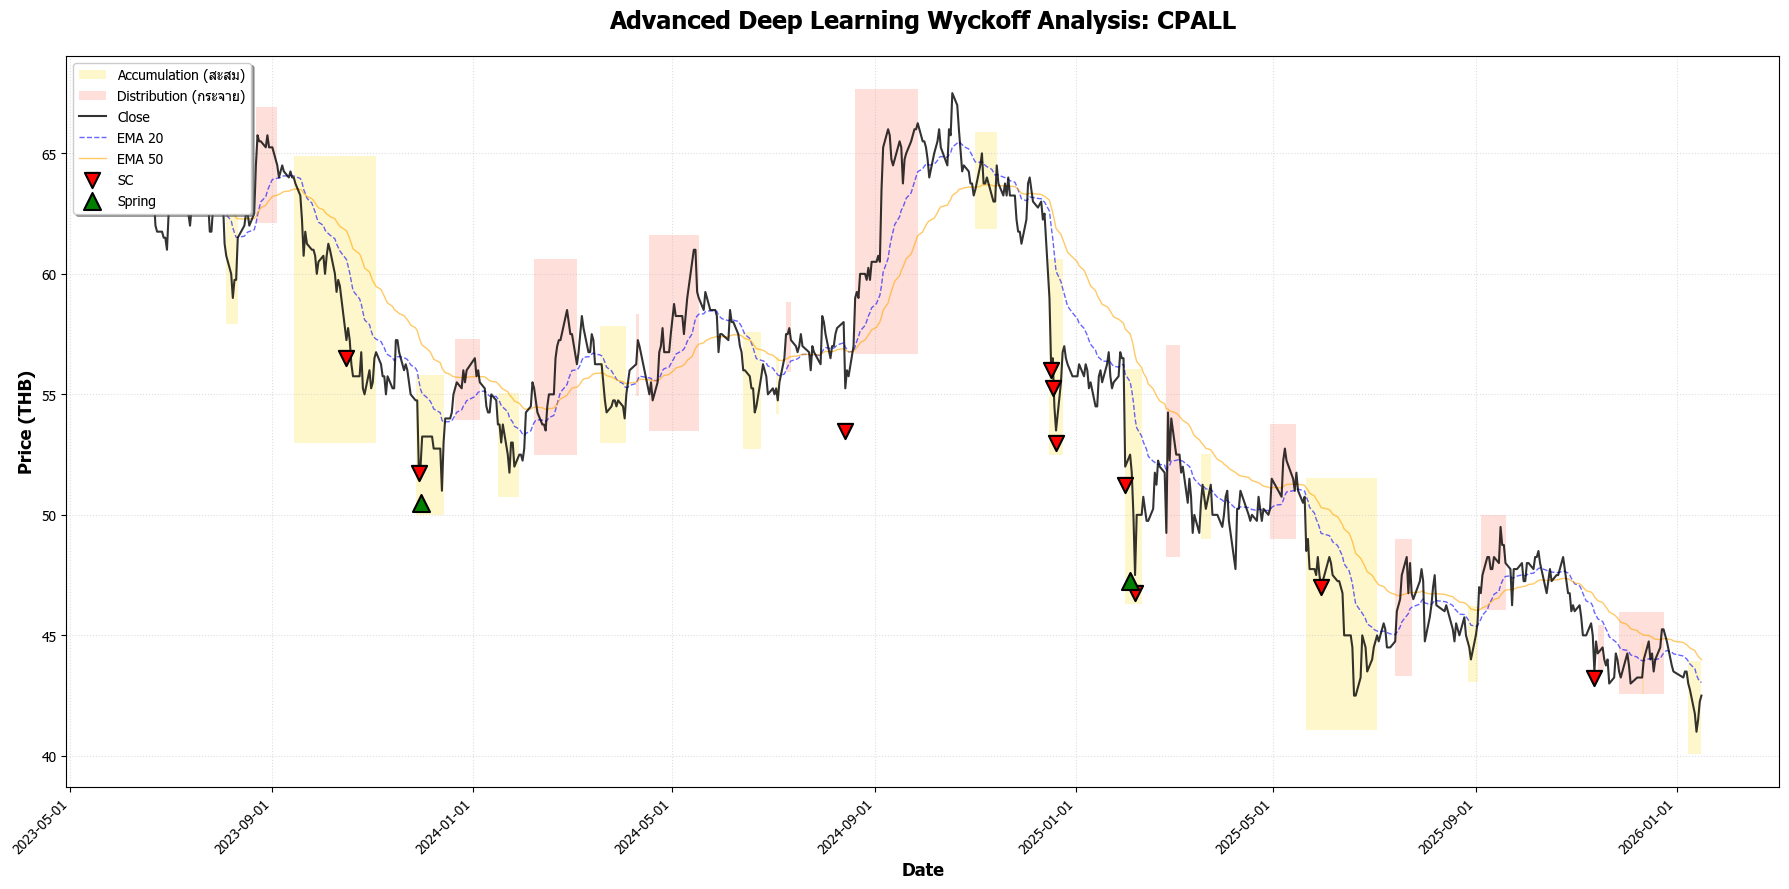

In [30]:
plot_dashboard(df_final, symbol=SYMBOL)
